In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("../../../../../results/usporedbaThermal/24/speed1/30min/merged_filtered.csv")



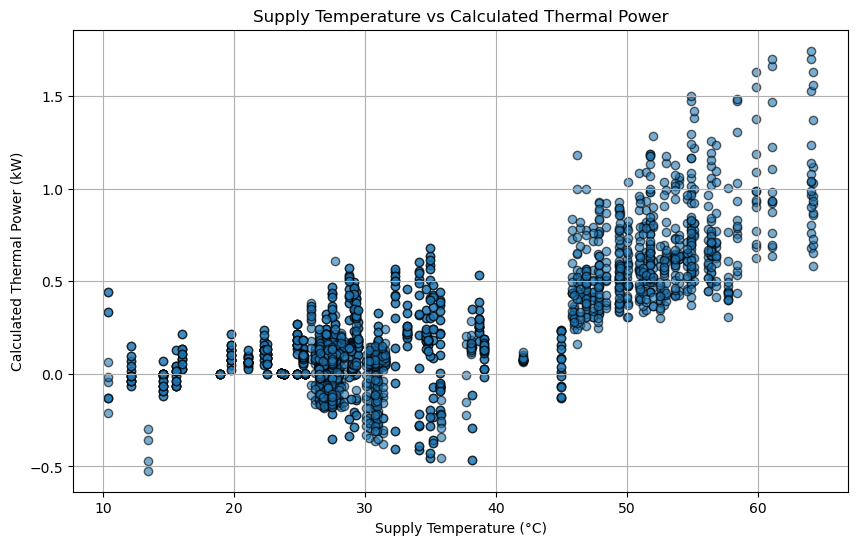

In [7]:

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    df['supply_temperature'],
    df['calculated_thermal_power'],
    alpha=0.6,
    edgecolor='k'
)

plt.title("Supply Temperature vs Calculated Thermal Power")
plt.xlabel("Supply Temperature (°C)")
plt.ylabel("Calculated Thermal Power (kW)")
plt.grid(True)
plt.show()

In [12]:
import pandas as pd


zone_ids = [195, 196, 197, 198, 199, 201, 202, 204, 205, 206, 207, 200, 203]

# Filter for zone_ids of interest
df_filtered = df[df['zone_id'].isin(zone_ids)].copy()

# Convert timestamp to datetime
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

# Add minute-level timestamp
df_filtered['minute'] = df_filtered['timestamp'].dt.floor('min')

# Step 1: Ensure each zone_id only counted once per minute
df_unique = (
    df_filtered
    .drop_duplicates(subset=['minute', 'zone_id'])
)

# Step 2: Group by minute
grouped = df_unique.groupby('minute')

# Step 3: Keep only minutes with all zone_ids present
complete_minutes = grouped.filter(lambda g: set(g['zone_id']) == set(zone_ids))

# Step 4: Sum calculated_thermal_power for complete minutes
result = (
    complete_minutes.groupby('minute')['calculated_thermal_power']
    .sum()
    .reset_index()
    .rename(columns={'calculated_thermal_power': 'total_thermal'})
)

# Step 5: Save to CSV
result.to_csv('total_thermal_per_minute.csv', index=False)

print(result.head())



               minute  total_thermal
0 2018-03-23 03:27:00       3.683594
1 2018-03-24 04:27:00       3.249457
2 2018-03-26 02:27:00       2.951673
3 2018-03-27 02:27:00       2.288543
4 2018-03-28 02:27:00       2.284092


                minute  total_thermal  thermal_power  difference  \
0  2018-03-23 03:27:00       3.683594            1.4    2.283594   
1  2018-03-24 04:27:00       3.249457            1.3    1.949457   
2  2018-03-26 02:27:00       2.951673            1.1    1.851673   
3  2018-03-27 02:27:00       2.288543            1.0    1.288543   
4  2018-03-28 02:27:00       2.284092            0.7    1.584092   
..                 ...            ...            ...         ...   
93 2021-12-28 05:43:00      -0.795820            2.4   -3.195820   
94 2021-12-29 05:43:00       0.758141            2.8   -2.041859   
95 2021-12-30 05:43:00       0.585876            2.2   -1.614124   
96 2021-12-31 05:43:00       0.456056            2.4   -1.943944   
97 2021-12-31 23:59:00       1.038434            0.4    0.638434   

    abs_difference  
0         2.283594  
1         1.949457  
2         1.851673  
3         1.288543  
4         1.584092  
..             ...  
93        3.195820  
94        2.041

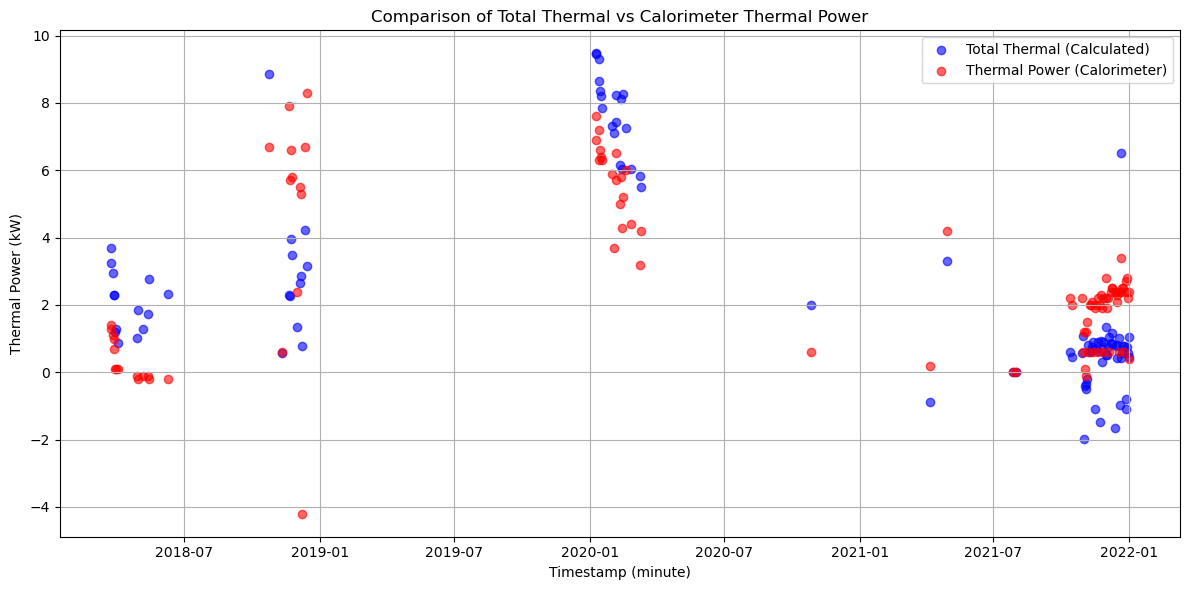

In [19]:
file_path_calorim = "../../../../../results/calorimeter_filtered24.csv"

data_calorim = pd.read_csv(file_path_calorim)
data_calorim['timestamp'] = pd.to_datetime(data_calorim['timestamp'])
data_calorim['minute'] = data_calorim['timestamp'].dt.floor('min')
data_calorim.columns = data_calorim.columns.str.strip()


comparison_df = pd.merge(
    result, 
    data_calorim[['minute', 'thermal_power']], 
    on='minute',
    how='inner'
)

# Optional: add a difference column

comparison_df['difference'] = comparison_df['total_thermal'] - comparison_df['thermal_power']
comparison_df['abs_difference'] = comparison_df['difference'].abs()

print(comparison_df)

average_abs_difference = comparison_df['abs_difference'].mean()
print("Average absolute difference:", average_abs_difference)
min_thermal=comparison_df['total_thermal'].min()
print("Min thermal: ", min_thermal)

plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(comparison_df['minute'], comparison_df['total_thermal'], 
            color='blue', alpha=0.6, label='Total Thermal (Calculated)')
plt.scatter(comparison_df['minute'], comparison_df['thermal_power'], 
            color='red', alpha=0.6, label='Thermal Power (Calorimeter)')

# Optional: line plot instead
# plt.plot(comparison_df['minute'], comparison_df['total_thermal'], color='blue', label='Total Thermal')
# plt.plot(comparison_df['minute'], comparison_df['thermal_power'], color='red', label='Thermal Power')

plt.xlabel("Timestamp (minute)")
plt.ylabel("Thermal Power (kW)")
plt.title("Comparison of Total Thermal vs Calorimeter Thermal Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
